In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint

import re
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
def generate_model_report(y_actual, y_pred):
    print("Accuracy:", accuracy_score(y_actual, y_pred))
    print("Precision:", precision_score(y_actual, y_pred, average='weighted')) # 'micro', 'macro'
    print("Recall:", recall_score(y_actual, y_pred, average='weighted'))
    print("F1 score:", f1_score(y_actual, y_pred, average='weighted'))

In [3]:
df = pd.read_csv(
    'Genre Classification Dataset/train_data.txt',
    sep=':::', 
    engine='python', 
    names=['title', 'genre', 'synopsis']
)

print(df.shape)
df.head()

(54214, 3)


,title,genre,synopsis
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [4]:
df_test = pd.read_csv(
    'Genre Classification Dataset/test_data_solution.txt',
    sep=':::', 
    engine='python', 
    names=['title', 'genre', 'synopsis']
)

print(df_test.shape)
df_test.head()

(54200, 3)


,title,genre,synopsis
1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


In [5]:
df = pd.concat((df, df_test), ignore_index=True)
print(df.shape)
df.head()

(108414, 3)


,title,genre,synopsis
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


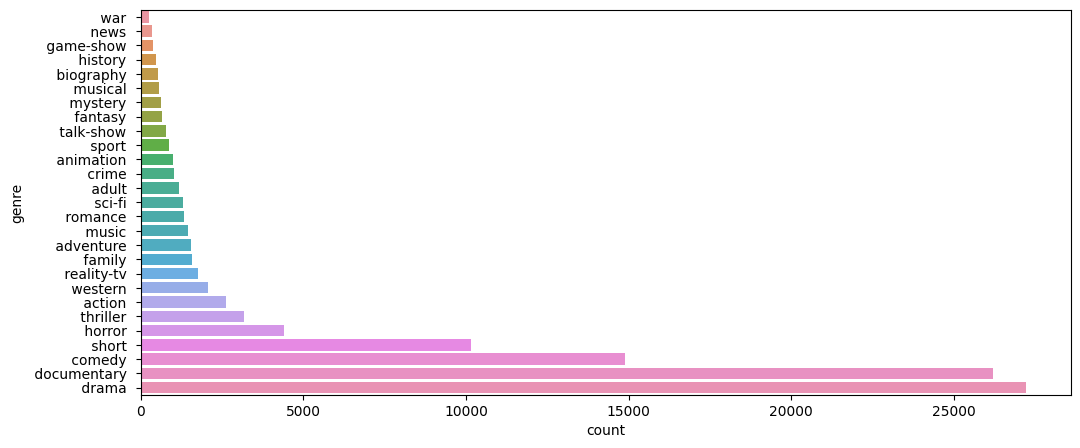

In [6]:
plt.figure(figsize=(12,5))
sns.countplot(y=df['genre'], order=df['genre'].value_counts(ascending=True).index)
plt.show()

# Data Cleaning

In [7]:
df.duplicated().sum()

0

In [8]:
df.isna().sum()

title       0
genre       0
synopsis    0
dtype: int64

In [9]:
df['length'] = df['synopsis'].apply(lambda x: len(x))
df.head()

,title,genre,synopsis,length
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625


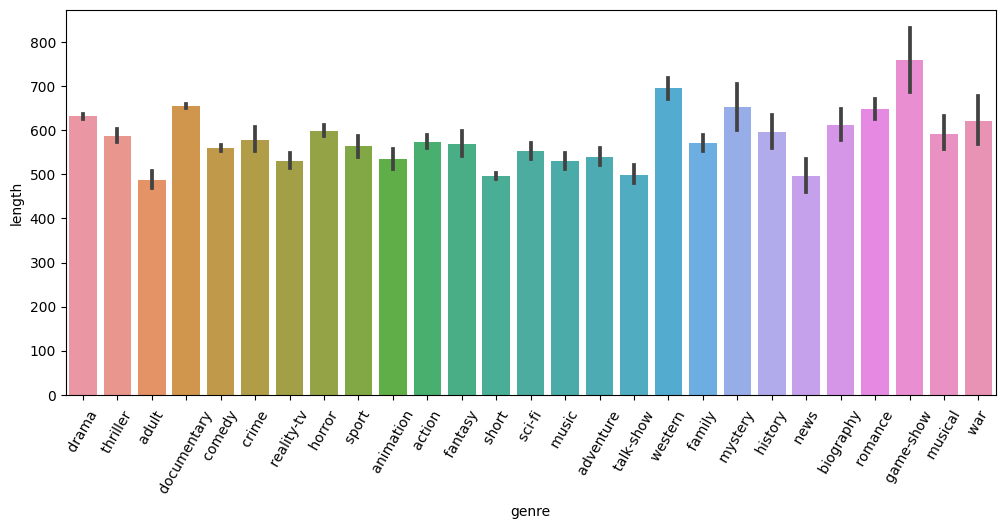

In [10]:
plt.figure(figsize=(12,5))
sns.barplot(x='genre', y='length', data=df)
plt.xticks(rotation=60)
plt.show()

In [11]:
wordnet = WordNetLemmatizer()

def cleaner(text):
    stop_words = set(stopwords.words('english'))
    text = re.sub('[^a-zA-Z]', ' ', text.lower())
    text = ' '.join([wordnet.lemmatize(word) for word in text.split() if not word in stop_words])
    return text

In [12]:
print("Before cleaning:", df['synopsis'].values[0])
print("\nAfter cleaning:", cleaner(df['synopsis'].values[0]))

Before cleaning:  Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.

After cleaning: listening conversation doctor parent year old oscar learns nobody courage tell week live furious refuse speak anyone except straight talking rose lady pink meet hospital stair christmas approach rose us fantastical experience professional wrestler imagination wit charm allow oscar live life love full company friend pop corn einstein bacon childhood sweetheart peggy blue


In [13]:
df['clean_synopsis'] = df['synopsis'].apply(cleaner)
df['clean_length'] = df['clean_synopsis'].apply(lambda x: len(x))

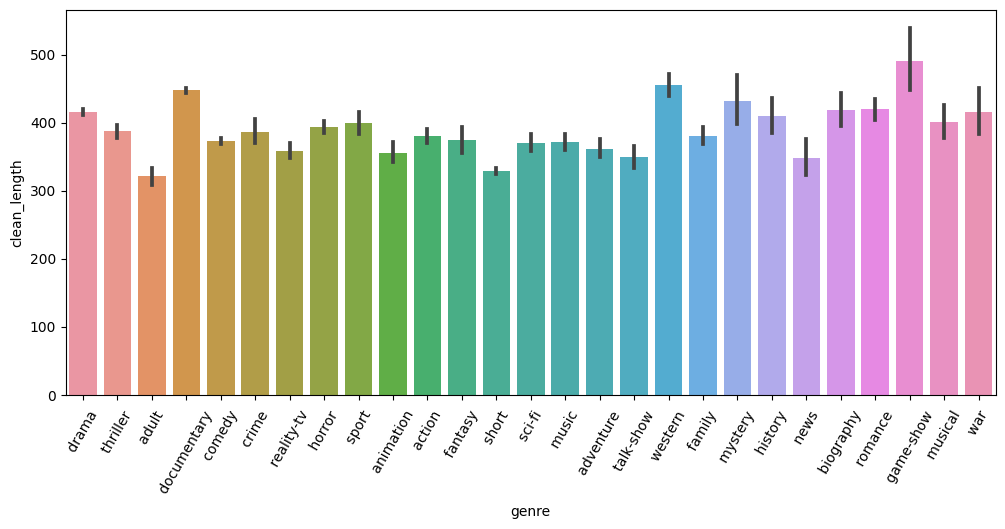

In [14]:
plt.figure(figsize=(12,5))
sns.barplot(x='genre', y='clean_length', data=df)
plt.xticks(rotation=60)
plt.show()

In [15]:
df.head()

,title,genre,synopsis,length,clean_synopsis,clean_length
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,listening conversation doctor parent year old ...,372
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,brother sister past incestuous relationship cu...,117
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty student field trip museum natural hi...,381
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemployed father make end meet edith twi...,729
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,film title refers un recovered body ground zer...,399


## Map Genres

In [16]:
genre_mapper = dict(zip(
    list(df['genre'].unique()),
    list(range(len(df['genre'].unique()))))
)

genre_mapper

{' drama ': 0,
 ' thriller ': 1,
 ' adult ': 2,
 ' documentary ': 3,
 ' comedy ': 4,
 ' crime ': 5,
 ' reality-tv ': 6,
 ' horror ': 7,
 ' sport ': 8,
 ' animation ': 9,
 ' action ': 10,
 ' fantasy ': 11,
 ' short ': 12,
 ' sci-fi ': 13,
 ' music ': 14,
 ' adventure ': 15,
 ' talk-show ': 16,
 ' western ': 17,
 ' family ': 18,
 ' mystery ': 19,
 ' history ': 20,
 ' news ': 21,
 ' biography ': 22,
 ' romance ': 23,
 ' game-show ': 24,
 ' musical ': 25,
 ' war ': 26}

In [17]:
df['genre'] = df['genre'].map(genre_mapper)
df.head()

,title,genre,synopsis,length,clean_synopsis,clean_length
0,Oscar et la dame rose (2009),0,Listening in to a conversation between his do...,546,listening conversation doctor parent year old ...,372
1,Cupid (1997),1,A brother and sister with a past incestuous r...,184,brother sister past incestuous relationship cu...,117
2,"Young, Wild and Wonderful (1980)",2,As the bus empties the students for their fie...,650,bus empty student field trip museum natural hi...,381
3,The Secret Sin (1915),0,To help their unemployed father make ends mee...,1082,help unemployed father make end meet edith twi...,729
4,The Unrecovered (2007),0,The film's title refers not only to the un-re...,625,film title refers un recovered body ground zer...,399


In [18]:
df.isna().any()

title             False
genre             False
synopsis          False
length            False
clean_synopsis    False
clean_length      False
dtype: bool

# Model

In [19]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_synopsis'].to_numpy())
y = df['genre'].values

In [20]:
X.shape, y.shape

((108414, 158640), (108414,))

### Train Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)
print('x_train size: {}, x_test size: {}'.format(X_train.shape, X_test.shape))

x_train size: (75889, 158640), x_test size: (32525, 158640)


### SVM Classifier

In [22]:
svm = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42)
svm.fit(X_train, y_train)

SGDClassifier(alpha=0.001, random_state=42)

In [23]:
y_pred_1 = svm.predict(X_test)

In [24]:
generate_model_report(y_test, y_pred_1)

print("Classification Report:\n", classification_report(y_test, y_pred_1))

Accuracy: 0.5487778631821676
Precision: 0.5220293161648087
Recall: 0.5487778631821676
F1 score: 0.48736326956563836
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.73      0.62      8095
           1       0.34      0.06      0.10       909
           2       0.73      0.27      0.39       355
           3       0.54      0.93      0.69      7877
           4       0.59      0.46      0.52      4526
           5       0.22      0.03      0.06       305
           6       0.60      0.13      0.21       527
           7       0.61      0.58      0.59      1360
           8       0.65      0.24      0.35       250
           9       0.42      0.09      0.14       313
          10       0.50      0.17      0.26       779
          11       0.28      0.05      0.08       193
          12       0.49      0.11      0.18      3070
          13       0.54      0.17      0.26       384
          14       0.58      0.23      0.32      

### NB Classifier

In [25]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [26]:
y_pred_2 = nb_classifier.predict(X_test)

In [27]:
generate_model_report(y_test, y_pred_2)

print("Classification Report:\n", classification_report(y_test, y_pred_2))

Accuracy: 0.44027671022290543
Precision: 0.3917440805221834
Recall: 0.44027671022290543
F1 score: 0.30220130328440736
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.88      0.53      8095
           1       0.00      0.00      0.00       909
           2       0.00      0.00      0.00       355
           3       0.53      0.90      0.66      7877
           4       0.62      0.04      0.07      4526
           5       0.00      0.00      0.00       305
           6       0.00      0.00      0.00       527
           7       0.00      0.00      0.00      1360
           8       0.00      0.00      0.00       250
           9       0.00      0.00      0.00       313
          10       0.00      0.00      0.00       779
          11       0.00      0.00      0.00       193
          12       0.90      0.00      0.01      3070
          13       0.00      0.00      0.00       384
          14       0.00      0.00      0.00    

## Logistic Regression

In [28]:
lg_regressor = LogisticRegression(multi_class='multinomial')
lg_regressor.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [29]:
y_pred_3 = lg_regressor.predict(X_test)

In [30]:
generate_model_report(y_test, y_pred_3)

print("Classification Report:\n", classification_report(y_test, y_pred_3))

Accuracy: 0.6007686395080707
Precision: 0.5823353204844511
Recall: 0.6007686395080707
F1 score: 0.5610419885471822
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.80      0.65      8095
           1       0.45      0.16      0.23       909
           2       0.74      0.26      0.38       355
           3       0.67      0.86      0.75      7877
           4       0.56      0.62      0.59      4526
           5       0.37      0.06      0.10       305
           6       0.56      0.23      0.33       527
           7       0.68      0.60      0.64      1360
           8       0.70      0.32      0.44       250
           9       0.70      0.07      0.12       313
          10       0.53      0.29      0.38       779
          11       0.40      0.02      0.04       193
          12       0.52      0.33      0.40      3070
          13       0.57      0.28      0.37       384
          14       0.67      0.42      0.52       

# Prediction

In [31]:
def prediction(text):
    stop_words = set(stopwords.words('english'))
    text = re.sub('[^a-zA-Z]', ' ', text.lower())
    text = ' '.join([wordnet.lemmatize(word) for word in text.split() if not word in stop_words])
    temp = vectorizer.transform([text]).toarray()
    genre = lambda x: list(genre_mapper.keys())[x]
    return {
        'SVM': genre(svm.predict(temp)[0]),
        'NB': genre(nb_classifier.predict(temp)[0]),
        'LG': genre(lg_regressor.predict(temp)[0])
    }

In [35]:
row = randint(0,df_test.shape[0]-1)
sample_script = df_test.synopsis[row]

print('Ttitle:', df_test.title[row])
print('\nScript: {}'.format(sample_script))
print('\nPrediction:', prediction(sample_script))
print('\nActual Genre:', df_test.genre[row])

Ttitle:  Judges (????) 

Script:  A young tomboy on life support is given a chance to come back to life to face her own giants by drawing strength from her out of body experiences with Old Testament Judges in the Bible in order stop a group of bullies who threaten to destroy other family's lives.

Prediction: {'SVM': ' drama ', 'NB': ' drama ', 'LG': ' drama '}

Actual Genre:  drama 


## Conclusion

In conclusion, the Logistic Regression model outperforms the SGD Classifier and Multinomial NB Classifier for the given task. With an accuracy of 0.60, precision of 0.58, recall of 0.60, and F1-score of 0.56, it consistently shows balanced performance across evaluation metrics, effectively capturing data complexities. Therefore, the logistic regression model is the optimal choice for this multi-class classification task.